# Zero-Noise Extrapolation (ZNE) with Indirect-Control System
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noise-free time-evolution with XY, Ising, and Heisenberg Hamiltonians.
- Time-constraint: True

## (1) Import and setup

In [1]:
# --- Standard Library ---
import os
import json
import textwrap
import importlib
import pprint  # Import the full module safely
from datetime import datetime

# --- Third-Party Libraries ---
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

In [3]:
BASE_PATH = "data"

ZNE_MODELS = ["xy-ric2",
            "ising-ric2",
            "heisenberg-ric2",
            "xy-ric3-uniform-scaling",
            "ising-ric3-uniform-scaling",
            "heisenberg-ric3-uniform-scaling",
            "xy-ric4-uniform-scaling",
            "ising-ric4-uniform-scaling",
            "heisenberg-ric4-uniform-scaling"
 
]

JSON_ENDS_WITH = {
    "vqe": "_vqe.json",
    "redundant": "_redundant.json",
    "zne": "_zne.json",
    "noiseoff": "_noise_off.json"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
]

time_stamp: bool = True
pdf_reports: bool = True
detailed_reports: bool = True

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [4]:
# Storage
ALL_RAW_DATA = {
    model: {key: [] for key in JSON_ENDS_WITH}
    for model in ZNE_MODELS
}

# Load loop
for model in ZNE_MODELS:
    model_path = os.path.join(BASE_PATH, model)
    if not os.path.isdir(model_path):
        print(f"[WARNING] Skipping missing dir: {model_path}")
        continue
    
    for filename in os.listdir(model_path):
        if not filename.endswith(".json"):
            continue
        
        filepath = os.path.join(model_path, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {filepath}: {e}")
            continue
        
        filename_lower = filename.lower()
        for key, suffix in JSON_ENDS_WITH.items():
            if filename_lower.endswith(suffix):
                ALL_RAW_DATA[model][key].append(data)
                break

## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.

### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [5]:
EXACT_SOL: float = -8.566772233505624
EXTRAPOL_TARGET = 0.0  # Extrapolated noise level
print(f"Exact solution: {EXACT_SOL}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}
    } for model in ZNE_MODELS
}

for model in ZNE_MODELS:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }
    # Based off the ZNE model, length of data points can be arbitrary
    n_levels = len(ALL_RAW_DATA[model]["redundant"][0]["output"]["data_points"])
    ALL_PROCESSED_DATA[model]["redundant"] = {
        "sorted_noise_levels": ALL_RAW_DATA[model]["zne"][0]["output"]["zne_values"]["others"]["sorted_noise"],
        "mean": [
            np.mean([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
        "std": [
            np.std([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
    }
   
    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }


In [7]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['sorted_noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model                            Category                  Mean       Std
-------------------------------  --------------------  --------  --------
xy-ric2                          vqe                   -7.37909  0.140519
xy-ric2                          redundant (noise=6)   -7.37909  0.140519
xy-ric2                          redundant (noise=18)  -5.82492  0.147749
xy-ric2                          zne                   -8.15618  0.143165
xy-ric2                          noiseoff              -8.36934  0.15125
ising-ric2                       vqe                   -6.58315  0.189154
ising-ric2                       redundant (noise=6)   -6.58315  0.189154
ising-ric2                       redundant (noise=18)  -5.38044  0.211325
ising-ric2                       zne                   -7.18451  0.180742
ising-ric2                       noiseoff              -7.28002  0.24691
heisenberg-ric2                  vqe                   -6.05646  0.180696
heisenberg-ric2                  redunda

## (4) Plot the results

Finally we can plot the results.

In [8]:
# Add timestamp if required
timestamp = ""
if time_stamp:
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
ALL_PLOTS = []

### Plotting functions

Standard single plotting:

In [9]:
import os
from typing import Any, Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
from pprint import pprint

def plot_zne_result(
    data: Dict[str, Any],
    extrapol_target: Union[float, List[float]],
    exact_solution: float,
    plot_colors: List[str],
    plot_title: str,
    plot_file_name: str,
    output_dir: str = f"reports/{timestamp}/plots",
    figsize: Tuple[float, float] = (4, 6),
    xlabel: str = r"Noise level ($\alpha_k\lambda$)",
    ylabel: str = "Expectation value",
    legend_loc: str = "upper left",
    legend_fontsize: int = 14,
    label_fontsize: int = 16,
    grid_style: Optional[Dict[str, Any]] = None,
    capsize: int = 5,
    save_format: str = "eps",
    show_plot: bool = True,
    print_data: bool = True
) -> plt.Figure:
    """
    Creates a ZNE result plot with noisy, extrapolated, noise-free, and exact solution lines.
    Returns the matplotlib Figure object for storage or later PDF compilation.

    Parameters
    ----------
    data : dict
        Nested dictionary with keys "redundant", "zne", and "noiseoff", each containing
        'sorted_noise_levels', 'mean', and 'std'.
    extrapol_target : float or list
        X-values for the extrapolated point(s).
    exact_solution : float
        Reference exact solution value.
    plot_colors : list
        List of colors; indices [0], [2], [5], [6] are used for noisy, extrapolated,
        exact, and noise-free points.
    plot_title : str
        Plot title.
    plot_file_name : str
        File name to save (include extension if desired).
    output_dir : str
        Directory to save the plot.
    figsize : tuple
        Figure size (width, height).
    xlabel, ylabel : str
        Axis labels.
    legend_loc : str
        Legend location.
    legend_fontsize : int
        Font size for legend text.
    label_fontsize : int
        Font size for axis labels.
    grid_style : dict, optional
        Grid style, e.g., {"linestyle": "--", "alpha": 0.6}.
    capsize : int
        Cap size for error bars.
    save_format : str
        File format for saving (eps, png, etc.).
    show_plot : bool
        Whether to display the plot immediately.
    print_data : bool
        Whether to pretty-print the data dictionary.

    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the plot, suitable for saving or adding to PDFs.
    """

    if grid_style is None:
        grid_style = {"linestyle": "--", "alpha": 0.6}

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=figsize)

    # --- Noisy estimation ---
    ax.errorbar(
        x=data["redundant"]["sorted_noise_levels"],
        y=data["redundant"]["mean"],
        yerr=data["redundant"]["std"],
        fmt="o",
        ecolor=plot_colors[0],
        capsize=capsize,
        label="Noisy estimation",
        color=plot_colors[0],
        markersize=5
    )

    # --- Extrapolated ---
    ax.errorbar(
        x=extrapol_target,
        y=data["zne"]["mean"],
        yerr=data["zne"]["std"],
        fmt="D",
        ecolor=plot_colors[2],
        capsize=capsize,
        label="Ric. ZNE value",
        color=plot_colors[2],
        markersize=5
    )

    # --- Noise-free ---
    ax.errorbar(
        x=0,
        y=data["noiseoff"]["mean"],
        yerr=data["noiseoff"]["std"],
        fmt="*",
        ecolor=plot_colors[6],
        capsize=capsize,
        label="Noise-free estimation",
        color=plot_colors[6],
        markersize=7
    )

    # --- Exact solution ---
    ax.axhline(
        y=exact_solution,
        color=plot_colors[5],
        linestyle="--",
        linewidth=1.5,
        label="Exact Solution"
    )

    # --- Labels, grid, legend ---
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_title(plot_title)
    ax.grid(**grid_style)
    ax.legend(loc=legend_loc, fontsize=legend_fontsize, frameon=False)

    # --- Save ---
    save_path = os.path.join(output_dir, plot_file_name)
    fig.savefig(save_path, format=save_format, bbox_inches='tight')
    print(f"✅ Figure saved as (in '{output_dir}' folder): {plot_file_name}")

    if print_data:
        pprint(data, sort_dicts=False, width=80)

    # --- Show or close ---
    if show_plot:
        # Only works in interactive backends
        plt.show()
    else:
        plt.close(fig)

    return fig

Compiled subplottings

In [10]:
def compile_zne_subplots(
    ALL_PROCESSED_DATA,
    models,
    plot_titles,
    plot_colors,
    EXACT_SOL,
    EXTRAPOL_TARGET,
    timestamp,
    output_dir=f"reports/{timestamp}/plots",
    filename_prefix="compiled_zne",
    ncols=3,
    figsize=(9, 6),
    show=True,
):
    """
    Create a compiled subplot figure.
    """

    nplots = len(models)
    nrows = (nplots + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    axs = axs.flatten() if nplots > 1 else [axs]

    for i, model in enumerate(models):
        ax = axs[i]
        DATA = ALL_PROCESSED_DATA[model]
        prefix = model.split("-")[0]
        title = plot_titles.get(prefix, model)

        # --- Noisy estimation ---
        ax.errorbar(
            x=DATA["redundant"]["sorted_noise_levels"],
            y=DATA["redundant"]["mean"],
            yerr=DATA["redundant"]["std"],
            fmt="o",
            ecolor=plot_colors[0],
            capsize=5,
            label="Noisy estimation",
            color=plot_colors[0],
            markersize=5
        )

        # --- ZNE Extrapolated ---
        ax.errorbar(
            x=EXTRAPOL_TARGET,
            y=DATA["zne"]["mean"],
            yerr=DATA["zne"]["std"],
            fmt="o",
            ecolor=plot_colors[2],
            capsize=5,
            label="Ric. ZNE value",
            color=plot_colors[2],
            markersize=5
        )

        # --- Noise-free estimation ---
        ax.errorbar(
            x=0,
            y=DATA["noiseoff"]["mean"],
            yerr=DATA["noiseoff"]["std"],
            fmt="*",
            ecolor=plot_colors[6],
            capsize=5,
            label="Noise-free estimation",
            color=plot_colors[6],
            markersize=7
        )

        # --- Exact solution ---
        ax.axhline(
            y=EXACT_SOL,
            color=plot_colors[5],
            linestyle="--",
            linewidth=1.5,
            label="Exact Solution"
        )

        # Titles and labels
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
        ax.grid(linestyle="--", alpha=0.6)
        if i % ncols == 0:
            ax.set_ylabel("Expectation value")

        # Legend consistent with single plot
        ax.legend(loc="upper left", fontsize=14, frameon=False)

    # Hide empty axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(w_pad=1.2, h_pad=0.3)
    plt.subplots_adjust(top=0.88)

    # Save compiled figure
    plot_file_name = f"{filename_prefix}_{timestamp}.eps"
    plt.savefig(f"{output_dir}/{plot_file_name}", format="eps")
    print(f"✅ Compiled figure saved: {output_dir}/{plot_file_name}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig

### #1 xy-ric2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): xy_ric2_20251014-140025.eps
{'vqe': {'mean': -7.379092083216174, 'std': 0.14051949985579798},
 'redundant': {'sorted_noise_levels': [6, 18],
               'mean': [-7.379092083216115, -5.824916251047478],
               'std': [0.14051949985579046, 0.14774914001898326]},
 'zne': {'mean': -8.156179999300434, 'std': 0.14316522047529753},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


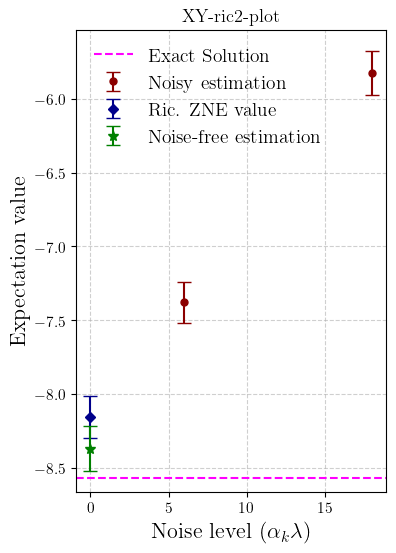

In [11]:
xy_ric2_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric2"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric2-plot",
    plot_file_name=f"xy_ric2_{timestamp}.eps",
)

### #2 ising-ric2-plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): isng_ric2_20251014-140025.eps
{'vqe': {'mean': -6.583152545992618, 'std': 0.18915423038578477},
 'redundant': {'sorted_noise_levels': [6, 18],
               'mean': [-6.583152545992628, -5.380444453773972],
               'std': [0.1891542303858078, 0.21132510224521175]},
 'zne': {'mean': -7.184506592101957, 'std': 0.18074166336647993},
 'noiseoff': {'mean': -7.2800222505553736, 'std': 0.24690963596051196}}


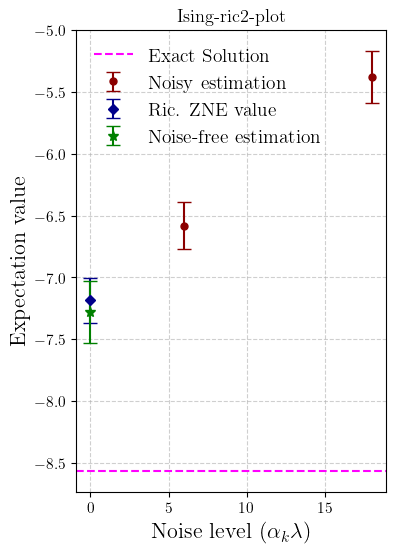

In [12]:
ising_ric2_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["ising-ric2"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="Ising-ric2-plot",
    plot_file_name=f"isng_ric2_{timestamp}.eps",
)

### #3 heisenberg-ric2 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): heisenberg_ric2_20251014-140025.eps
{'vqe': {'mean': -6.056457299952753, 'std': 0.1806957231807042},
 'redundant': {'sorted_noise_levels': [6, 18],
               'mean': [-6.056457299952716, -4.591528569882987],
               'std': [0.18069572318071422, 0.1722786909703192]},
 'zne': {'mean': -6.788921664987581, 'std': 0.1942120188478231},
 'noiseoff': {'mean': -6.9205461139528435, 'std': 0.19766791757742266}}


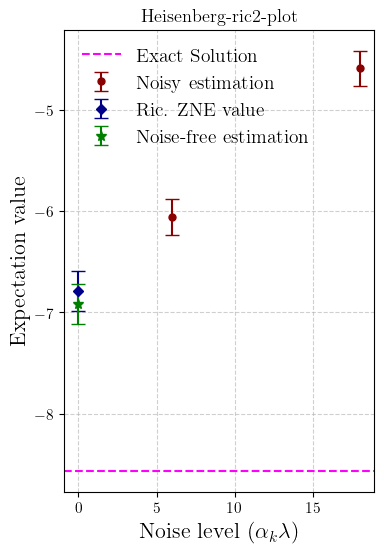

In [13]:
heisenberg_ric2_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["heisenberg-ric2"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="Heisenberg-ric2-plot",
    plot_file_name=f"heisenberg_ric2_{timestamp}.eps",
)

### #4 Compiled ric-2 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Compiled figure saved: reports/20251014-140025/plots/compiled_ric2_20251014-140025.eps


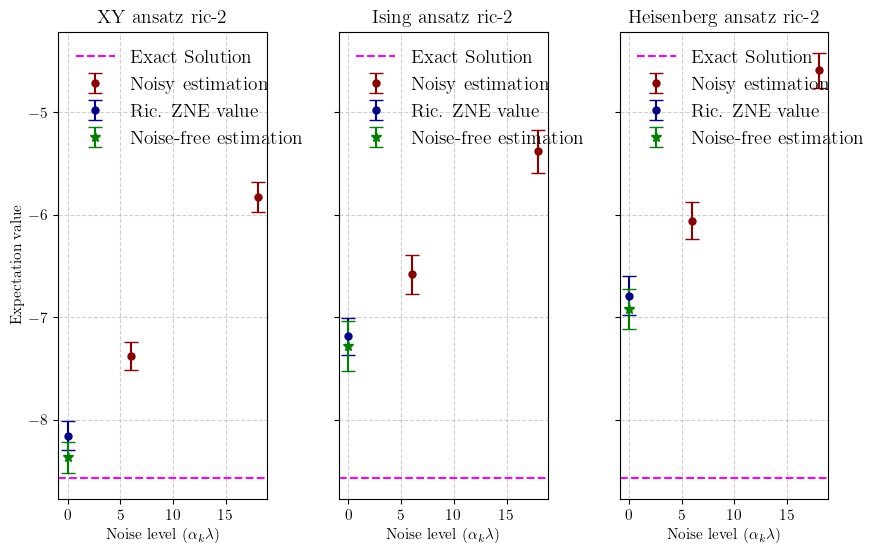

In [14]:
plot_titles = {
    "xy": "XY ansatz ric-2",
    "ising": "Ising ansatz ric-2",
    "heisenberg": "Heisenberg ansatz ric-2"
}

models_to_plot = ["xy-ric2", "ising-ric2", "heisenberg-ric2"]

ric2_compiled_plt = compile_zne_subplots(
    ALL_PROCESSED_DATA=ALL_PROCESSED_DATA,
    models=models_to_plot,
    plot_titles=plot_titles,
    plot_colors=plot_colors,
    EXACT_SOL=EXACT_SOL,
    EXTRAPOL_TARGET=EXTRAPOL_TARGET,
    timestamp=timestamp,
    ncols=3,
    figsize=(9, 6),
    filename_prefix="compiled_ric2"
)

### #5 xy-ric3 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): xy_ric3_uniform-scaling_20251014-140025.eps
{'vqe': {'mean': -7.379092083216174, 'std': 0.14051949985579798},
 'redundant': {'sorted_noise_levels': [6, 18, 30],
               'mean': [-7.379092083216115,
                        -5.824916251047478,
                        -4.625587525002892],
               'std': [0.14051949985579038,
                       0.14774914001898334,
                       0.15659822337063675]},
 'zne': {'mean': -8.289247664096953, 'std': 0.14534054327105433},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}


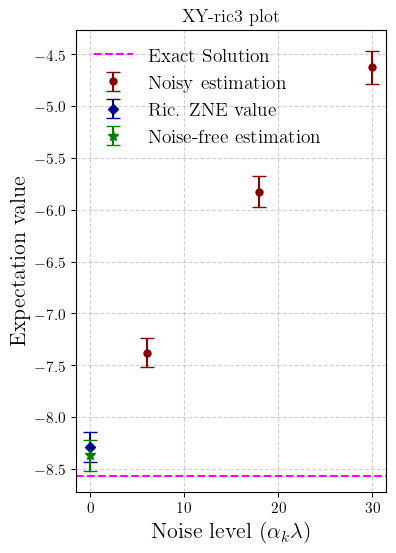

In [15]:
xy_ric3_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["xy-ric3-uniform-scaling"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="XY-ric3 plot",
    plot_file_name=f"xy_ric3_uniform-scaling_{timestamp}.eps",
)

### #6 ising-ric3 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): ising_ric3_uniform-scaling_20251014-140025.eps
{'vqe': {'mean': -6.583152545992618, 'std': 0.18915423038578477},
 'redundant': {'sorted_noise_levels': [6, 18, 30],
               'mean': [-6.583152545992628,
                        -5.380444453773972,
                        -4.399237263087257],
               'std': [0.18915423038580764,
                       0.21132510224521167,
                       0.22364531027020002]},
 'zne': {'mean': -7.267569430176434, 'std': 0.17709576398475688},
 'noiseoff': {'mean': -7.2800222505553736, 'std': 0.24690963596051196}}


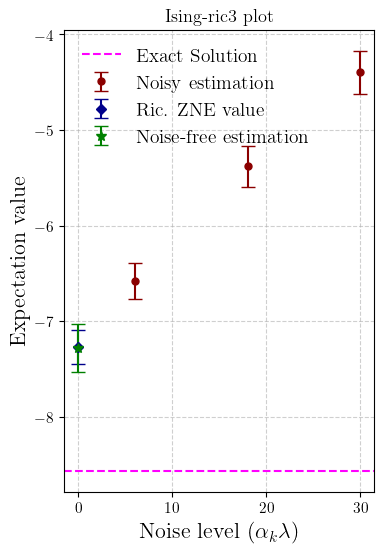

In [16]:
ising_ric3_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["ising-ric3-uniform-scaling"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="Ising-ric3 plot",
    plot_file_name=f"ising_ric3_uniform-scaling_{timestamp}.eps",
)

### #7 heisenberg-ric3 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Figure saved as (in 'reports/20251014-140025/plots' folder): heisenberg_ric3_uniform-scaling_20251014-140025.eps
{'vqe': {'mean': -6.056457299952753, 'std': 0.1806957231807042},
 'redundant': {'sorted_noise_levels': [6, 18, 30],
               'mean': [-6.056457299952716,
                        -4.591528569882987,
                        -3.46106549714463],
               'std': [0.18069572318071422,
                       0.1722786909703191,
                       0.1756168390798456]},
 'zne': {'mean': -6.914346286486845, 'std': 0.19704715393657893},
 'noiseoff': {'mean': -6.9205461139528435, 'std': 0.19766791757742266}}


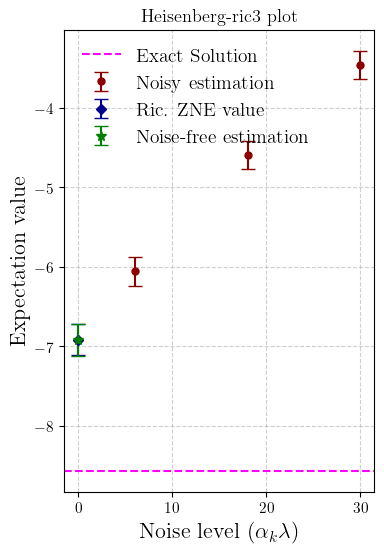

In [17]:
heisenberg_ric3_plt = plot_zne_result(
    data=ALL_PROCESSED_DATA["heisenberg-ric3-uniform-scaling"],
    extrapol_target=EXTRAPOL_TARGET,
    exact_solution=EXACT_SOL,
    plot_colors=plot_colors,
    plot_title="Heisenberg-ric3 plot",
    plot_file_name=f"heisenberg_ric3_uniform-scaling_{timestamp}.eps",
)

### #8 Compiled ric-3 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Compiled figure saved: reports/20251014-140025/plots/compiled_ric3_20251014-140025.eps


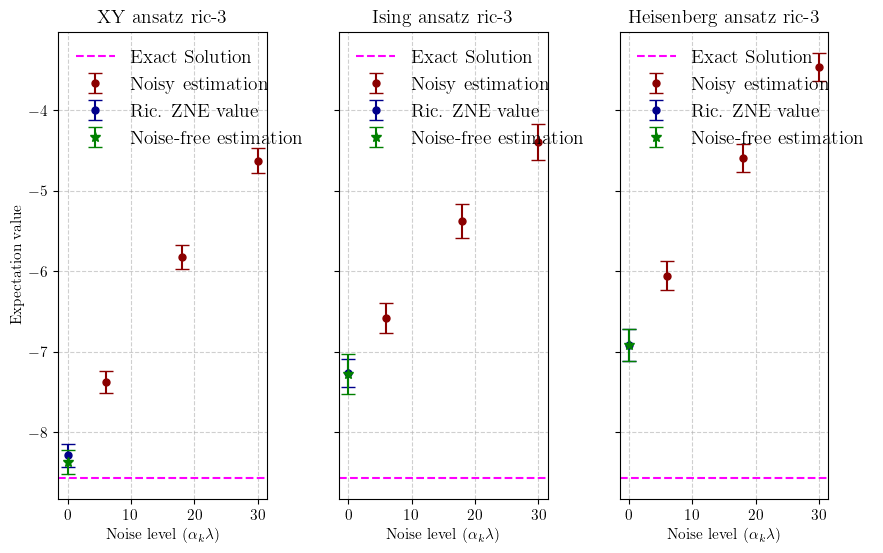

In [18]:
plot_titles = {
    "xy": "XY ansatz ric-3",
    "ising": "Ising ansatz ric-3",
    "heisenberg": "Heisenberg ansatz ric-3"
}

models_to_plot = ["xy-ric3-uniform-scaling", "ising-ric3-uniform-scaling", "heisenberg-ric3-uniform-scaling"]

ric3_compiled_plt = compile_zne_subplots(
    ALL_PROCESSED_DATA=ALL_PROCESSED_DATA,
    models=models_to_plot,
    plot_titles=plot_titles,
    plot_colors=plot_colors,
    EXACT_SOL=EXACT_SOL,
    EXTRAPOL_TARGET=EXTRAPOL_TARGET,
    timestamp=timestamp,
    ncols=3,
    figsize=(9, 6),
    filename_prefix="compiled_ric3"
)

### #9 Compiled ric-4 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Compiled figure saved: reports/20251014-140025/plots/compiled_ric4_20251014-140025.eps


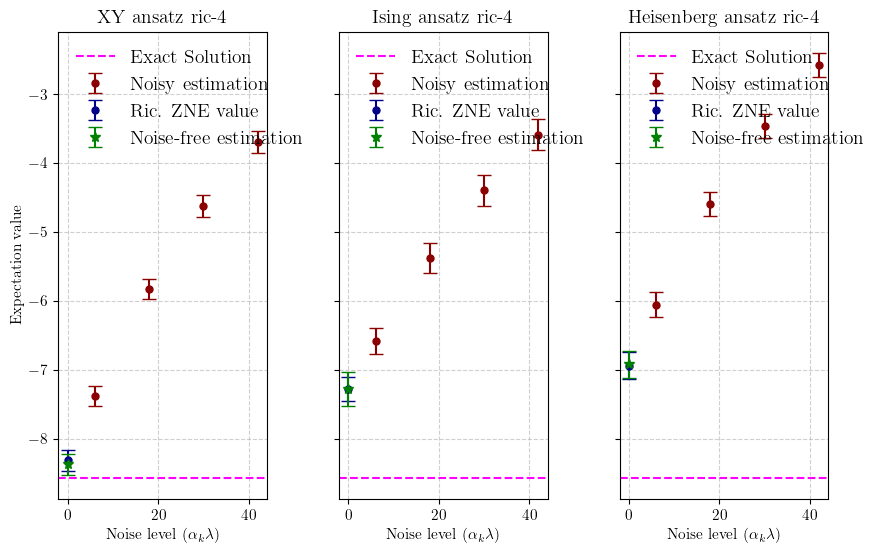

In [19]:
plot_titles = {
    "xy": "XY ansatz ric-4",
    "ising": "Ising ansatz ric-4",
    "heisenberg": "Heisenberg ansatz ric-4"
}

models_to_plot = ["xy-ric4-uniform-scaling", "ising-ric4-uniform-scaling", "heisenberg-ric4-uniform-scaling"]

ric4_compiled_plt = compile_zne_subplots(
    ALL_PROCESSED_DATA=ALL_PROCESSED_DATA,
    models=models_to_plot,
    plot_titles=plot_titles,
    plot_colors=plot_colors,
    EXACT_SOL=EXACT_SOL,
    EXTRAPOL_TARGET=EXTRAPOL_TARGET,
    timestamp=timestamp,
    ncols=3,
    figsize=(9, 6),
    filename_prefix="compiled_ric4"
)

## (7) Summary

In [20]:
def summarize_zne_results(
    ALL_PROCESSED_DATA,
    selected_models,
    column_labels: list | None = None,
    decimals: int = 5,
    mean_std_symbol: str = "±",
    font_size: int = 10,
    row_scale: float = 1.25,
    color_rows: bool = True,
    output_dir: str = f"reports/{timestamp}/artifacts",
    save_name: str | None = None,
    save_formats: list = ["eps", "csv"],
    print_data: bool = True,
    figsize: tuple = (8, None)
):
    """
    Create a professional summary table for ZNE results (tight layout, no title).

    Parameters
    ----------
    ALL_PROCESSED_DATA : dict
        Nested dictionary containing processed ZNE data.
    selected_models : list
        List of model names to include.
    column_labels : list, optional
        List of column labels. Default: ["Description", "Simulation", "Mean ± Std"]
    decimals : int
        Number of decimals to show in mean ± std.
    mean_std_symbol : str
        Symbol between mean and std.
    font_size : int
        Font size for table.
    row_scale : float
        Row height scaling.
    color_rows : bool
        Whether to color rows by model.
    output_dir : str
        Directory to save files.
    save_name : str, optional
        Base file name (without extension).
    save_formats : list
        List of formats to save: any of ["eps", "png", "csv", "latex"].
    print_data : bool
        Whether to print the dataframe.
    figsize : tuple
        Figure width and optional height (height auto if None).
    """
    os.makedirs(output_dir, exist_ok=True)

    if column_labels is None:
        column_labels = ["Description", "Simulation", "Mean ± Std"]

    # --- Helper to format mean ± std ---
    def fmt_mean_std(mean, std):
        if mean is None or std is None:
            return "N/A"
        return f"{mean:.{decimals}f} {mean_std_symbol} {std:.{decimals}f}"

    # --- Prepare rows ---
    rows = []
    for model, methods in ALL_PROCESSED_DATA.items():
        if model not in selected_models:
            continue
        for method, stats in methods.items():
            if method == "redundant":
                for lvl, m, s in zip(stats['sorted_noise_levels'], stats['mean'], stats['std']):
                    rows.append([model, f"{method} (noise={lvl})", fmt_mean_std(m, s)])
            elif stats:
                rows.append([model, method, fmt_mean_std(stats['mean'], stats['std'])])
            else:
                rows.append([model, method, "N/A"])
        rows.append(["", "", ""])  # empty row between models

    df = pd.DataFrame(rows, columns=column_labels)

    if print_data:
        print("=== Summary Table ===")
        pprint(df, sort_dicts=False, width=120)

    # --- Save CSV / LaTeX ---
    if save_name:
        for fmt in save_formats:
            path = f"{output_dir}/{save_name}.{fmt}"
            if fmt.lower() == "csv":
                df.to_csv(path, index=False)
            elif fmt.lower() == "latex":
                with open(path, "w") as f:
                    f.write(df.to_latex(index=False))
            elif fmt.lower() in ["eps", "png"]:
                continue
            else:
                raise ValueError(f"Unsupported format: {fmt}")

    # --- Create figure ---
    n_rows = len(df)
    if figsize[1] is None:
        fig_height = max(2, n_rows * 0.35)
    else:
        fig_height = figsize[1]

    fig, ax = plt.subplots(figsize=(figsize[0], fig_height))
    ax.axis('off')

    # Table occupies full figure (tight layout)
    table_bbox = [0, 0, 1, 1]

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        bbox=table_bbox
    )

    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    table.scale(1, row_scale)

    # --- Color rows by model ---
    if color_rows:
        unique_models = {m.lower().strip() for m in df[column_labels[0]] if m.strip() != ""}
        colors = cm.Pastel1(np.linspace(0, 1, len(unique_models)))
        model_colors = {model: colors[i] for i, model in enumerate(sorted(unique_models))}
        for i, model_name in enumerate(df[column_labels[0]]):
            key = model_name.strip().lower()
            color = model_colors.get(key, "#f0f0f0") if key != "" else "#f0f0f0"
            for j in range(len(df.columns)):
                table[(i + 1, j)].set_facecolor(color)

    # --- Save figure ---
    if save_name:
        for fmt in save_formats:
            if fmt.lower() in ["eps", "png"]:
                path = f"{output_dir}/{save_name}.{fmt}"
                plt.savefig(path, format=fmt.lower(), bbox_inches='tight')
                print(f"✅ Saved figure: {path}")

    plt.show()
    return df, fig

=== Summary Table ===
                        Description            Simulation          Mean ± Std
0                           xy-ric2                   vqe  -7.37909 ± 0.14052
1                           xy-ric2   redundant (noise=6)  -7.37909 ± 0.14052
2                           xy-ric2  redundant (noise=18)  -5.82492 ± 0.14775
3                           xy-ric2                   zne  -8.15618 ± 0.14317
4                           xy-ric2              noiseoff  -8.36934 ± 0.15125
..                              ...                   ...                 ...
58  heisenberg-ric4-uniform-scaling  redundant (noise=30)  -3.46107 ± 0.17562
59  heisenberg-ric4-uniform-scaling  redundant (noise=42)  -2.58067 ± 0.17819
60  heisenberg-ric4-uniform-scaling                   zne  -6.94072 ± 0.19769
61  heisenberg-ric4-uniform-scaling              noiseoff  -6.92055 ± 0.19767
62                                                                           

[63 rows x 3 columns]
✅ Saved figure: rep

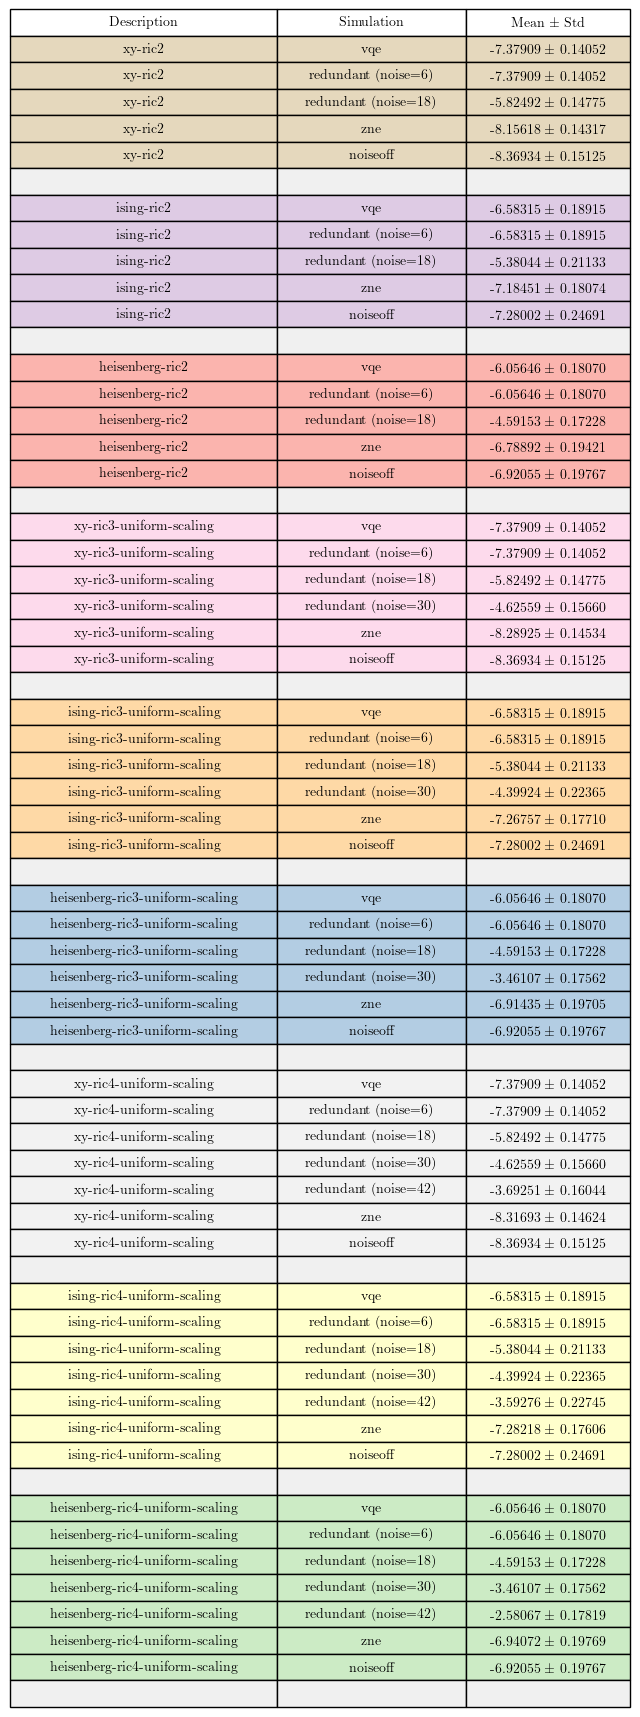

In [21]:
df_summary, fig = summarize_zne_results(
    ALL_PROCESSED_DATA=ALL_PROCESSED_DATA,
    selected_models=ZNE_MODELS,
    decimals=5,
    font_size=10,
    row_scale=1.3,
    save_name=f"zne_summary_{timestamp}",
    save_formats=["eps","csv","latex"]
)

# Appendix
---

### PDF report

In [22]:
CONFIG_SUMMARY: dict = {
    "xy": ALL_RAW_DATA["xy-ric2"]["vqe"][0]["config"],
    "ising": ALL_RAW_DATA["ising-ric2"]["vqe"][0]["config"],
    "heisenberg": ALL_RAW_DATA["heisenberg-ric2"]["vqe"][0]["config"],
}
ALL_PLOTS = [
    ric2_compiled_plt,
    ric3_compiled_plt, 
    ric4_compiled_plt
]

In [23]:
HEIGHT = 0.2
WIDTH = 5
FILE_NAME = f"reports/{timestamp}/artifacts/summary.pdf"

# Flatten deeply nested dicts
def flatten_config(config, prefix=""):
    flat = {}
    for k, v in config.items():
        full_key = f"{prefix}{k}"
        if isinstance(v, dict):
            flat.update(flatten_config(v, prefix=full_key + "."))
        else:
            flat[full_key] = v
    return flat

def render_model_config_page(model_name, config_dict):
    flat_config = flatten_config(config_dict)
    df = pd.DataFrame(list(flat_config.items()), columns=["Parameter", "Value"])

    # Estimate height dynamically
    row_height = HEIGHT  # inches per row
    max_width = WIDTH  # keep A4 landscape width if needed
    fig_height = max(2, min(len(df) * row_height + 1.5, 11))

    fig = plt.figure(figsize=(max_width, fig_height))
    ax = fig.add_axes([0, 0, 1, 1])  # Full area, no margin
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='left',
        loc='center',
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.3)  # Adjust row height for readability

    # Color header row
    for j in range(len(df.columns)):
        table[(0, j)].set_fontsize(9)
        table[(0, j)].set_facecolor("#dddddd")
        table[(0, j)].set_text_props(weight='bold')

    # Add title manually
    fig.text(0.5, 0.98, f"{model_name.upper()} VQE CONFIGURATION", ha='center', fontsize=12, weight='bold')

    return fig

if pdf_reports:
    with PdfPages(FILE_NAME) as pdf:
        # Save a main figure (if any)
        pdf.savefig(fig, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
        
        # Save multiple stored figures
        for stored_fig in ALL_PLOTS:
            pdf.savefig(stored_fig, bbox_inches='tight', pad_inches=0.05)
            plt.close(stored_fig)
        
        # Save config summary pages
        for model, config in CONFIG_SUMMARY.items():
            config_fig = render_model_config_page(model, config)
            pdf.savefig(config_fig, bbox_inches='tight', pad_inches=0.1)
            plt.close(config_fig)
        
        print("Result summary saved as PDF:", FILE_NAME)
else:
    print("PDF report generation skipped.")

Result summary saved as PDF: reports/20251014-140025/artifacts/summary.pdf


In [24]:
import textwrap
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Preformatted
from reportlab.lib.styles import ParagraphStyle

def export_raw_data_wrapped(all_raw_data: dict, pdf_filename="VQE_Raw_Data_Wrapped.pdf",
                            font_size=8, wrap_width=120):
    """
    Export a Python dictionary to PDF as a wrapped code block.
    This version isolates pprint to avoid shadowing issues in Jupyter.
    """
    # --- Local import of the real pprint module ---
    import importlib, sys
    import pprint as real_pprint
    importlib.reload(real_pprint)

    # Convert dict to pretty string
    raw_text = real_pprint.pformat(all_raw_data, indent=2, width=wrap_width)

    # Wrap each line to wrap_width characters
    import textwrap
    wrapped_lines = []
    for line in raw_text.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=wrap_width, replace_whitespace=False) or [''])
    wrapped_text = "\n".join(wrapped_lines)

    # PDF setup with minimal margins
    doc = SimpleDocTemplate(pdf_filename, pagesize=letter,
                            leftMargin=0.2*72, rightMargin=0.2*72,
                            topMargin=0.2*72, bottomMargin=0.2*72)

    # Monospace style for code block
    code_style = ParagraphStyle(
        'codeblock',
        fontName='Courier',
        fontSize=font_size,
        leading=font_size + 2,
        leftIndent=0,
        rightIndent=0,
        spaceBefore=0,
        spaceAfter=0
    )

    # Build PDF
    doc.build([Preformatted(wrapped_text, code_style)])
    print(f"✅ PDF saved as '{pdf_filename}'")


In [25]:
if detailed_reports:
    export_raw_data_wrapped(ALL_RAW_DATA, pdf_filename=f"reports/{timestamp}/artifacts/big_json_{timestamp}.pdf")
else:
    print("Detailed raw data PDF export skipped.")

✅ PDF saved as 'reports/20251014-140025/artifacts/big_json_20251014-140025.pdf'
